# Exploración I: Regresión logística

El objetivo general de la primera exploración consiste en tener unas primeras ideas sobre la cantidad de rezagos que el modelo debe conocer y el horizonte de predicción en minutos.

In [1]:
#Librerias necesarias para la ejecución
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel("arb.xlsx") #Cargue de la base de datos
print("Tamaño de la base de datos: \nFilas: {row} \nColumnas:{col}".format(row=df.shape[0], col=df.shape[1]))
df.head()

Tamaño de la base de datos: 
Filas: 50406 
Columnas:25


,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,CIB_ABIERTO,...,USD_BID,USD_ASK,ASK_CIB,BID_CIB,ASK_PFB,BID_PFB,Spread_BE_SL,Spread_BL_SE,Arbitraje_BE_SL,Arbitraje_BL_SE
0,2022-01-03,9,54,9,0,0,0,0,1,1,...,4073.00,4076.9,31.74,31.55,32300,32010,-352.32380,-186.30125,0,0
1,2022-01-03,9,55,9,0,0,0,0,1,1,...,4072.72,4076.0,31.75,31.58,32300,32290,-75.37175,-157.96754,0,0
2,2022-01-03,9,56,9,0,0,0,0,1,1,...,4072.72,4076.0,31.76,31.60,32300,32290,-85.56300,-137.60644,0,0
3,2022-01-03,9,57,9,0,0,0,0,1,1,...,4072.72,4075.0,31.76,31.60,32300,32290,-77.62100,-137.60644,0,0
4,2022-01-03,9,58,9,0,0,0,0,1,1,...,4072.00,4075.0,31.76,31.62,32300,32290,-77.62100,-122.93550,0,0


Se van a explorar modelos con horizontes de predicción de hasta 10 minutos con rezagos de información de hasta 10 observaciones de precios. La predicción se intentará realizar para cada tipo de arbitraje por separado, para predecir arbitraje independiente de su forma y predicción multiclase.

In [3]:
#Crea columna de arbitraje independiente de su forma
df["Arbitraje_Ind"]=df['Arbitraje_BE_SL']+df['Arbitraje_BL_SE']
#Crea columna de arbitraje multiclase
df.loc[df['Arbitraje_BE_SL']==1, "Arbitraje_Mul"]=1
df.loc[df['Arbitraje_BL_SE']==1, "Arbitraje_Mul"]=2
df["Arbitraje_Mul"].fillna(0, inplace=True)

## 1. Predicción independiente de la forma de arbitraje

In [4]:
#Columnas con información de mercado
model_cols=["Festivo_COL", "Festivo_NYSE", "Next_Day", "Subasta", "PFB_ABIERTO",
            "CIB_ABIERTO", "CIB_close", "COP_close","PFB_close", "Arbitraje_Ind"]

In [5]:
#Desplazamiento de la columna de arbitraje en n minutos (1 a 10 minutos) y rezagos de precios de hasta 10 observaciones
df_ind=df.copy()
for i in range(1,11):
    col="Target_arb "+str(i)
    col2="COP_close - "+str(i)
    col3="CIB_close - "+str(i)
    col4="PFB_close - "+str(i)
    
    df_ind[col]=df_ind["Arbitraje_Ind"].shift(-i)
    df_ind[col2]=df_ind["COP_close"].shift(i)
    df_ind[col3]=df_ind["CIB_close"].shift(i)
    df_ind[col4]=df_ind["PFB_close"].shift(i)

In [6]:
resultados_globales=[]
for state in range(1,11):
    for i in range(1,11):
        for p in range(1,11):

            y_col="Target_arb "+str(i)

            cols_lags=[]
            for k in range(1, p+1):

                cols_lags= cols_lags + [x for x in list(df_ind.columns) if "close - "+str(k) in x]

            if p!=10:
                cols_lags=[x for x in cols_lags if "close - 10" not in x]

            new_model_cols=model_cols.copy()
            new_model_cols.append(y_col)

            new_model_cols=new_model_cols+cols_lags

            model_data=df_ind[new_model_cols]
            model_data.dropna(inplace=True)
            X=model_data.drop(y_col, axis=1)
            Y=model_data[y_col]
            x_train, x_test, y_train, y_test = train_test_split(X, 
                                                           Y,random_state=state,
                                                           shuffle=True, stratify=Y)

            l_reg=lr()
            l_reg.fit(x_train, y_train)
            y_pred = l_reg.predict(x_test)
            presicion=precision_score(y_test, y_pred, average="macro")
            recall=recall_score(y_test, y_pred, average="macro")
            f1=f1_score(y_test, y_pred, average="macro")

            cols_str=str()
            for w in new_model_cols:
                cols_str=cols_str+w+","

            resultados_globales.append([str(i),str(p), presicion, recall, f1, cols_str,])

In [7]:
resultados = pd.DataFrame(resultados_globales, columns = ['Horizonte Arb', 'Rezagos precios', 
                                                          'precision', 'recall', 'f1','cols_str'])
resultados.sample(10)

,Horizonte Arb,Rezagos precios,precision,recall,f1,cols_str
183,9,4,0.406104,0.500000,0.448187,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
472,8,3,0.818649,0.581574,0.596210,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
347,5,8,0.406089,0.499902,0.448138,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
892,10,3,0.808028,0.559977,0.562298,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
958,6,9,0.656121,0.500162,0.448600,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
315,2,6,0.406071,0.500000,0.448167,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
350,6,1,0.801133,0.692622,0.726067,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
261,7,2,0.406071,0.500000,0.448167,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
733,4,4,0.406064,0.499951,0.448143,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
221,3,2,0.406079,0.500000,0.448172,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."


In [8]:
table_precision = pd.pivot_table(resultados, values='precision', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_precision=table_precision[["1","2","3","4","5","6","7","8","9","10"]]         
table_precision.index = table_precision.index.astype("int")                
table_precision.sort_index(ascending=True, inplace=True)

table_precision2 = pd.pivot_table(resultados, values='precision', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_precision2=table_precision2[["1","2","3","4","5","6","7","8","9","10"]]         
table_precision2.index = table_precision2.index.astype("int")                
table_precision2.sort_index(ascending=True, inplace=True)

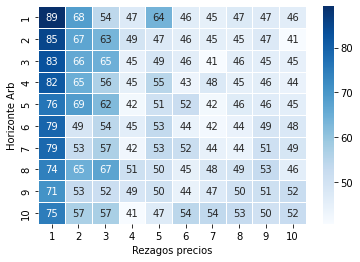

In [9]:
sns.heatmap(table_precision*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 1/Precision.png')

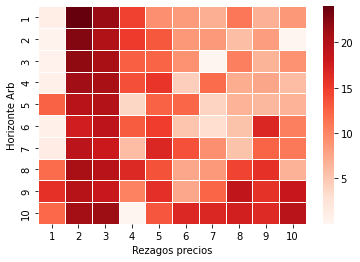

In [10]:
sns.heatmap(table_precision2*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 1/Precision2.png')

In [11]:
table_recall = pd.pivot_table(resultados, values='recall', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_recall=table_recall[["1","2","3","4","5","6","7","8","9","10"]]         
table_recall.index = table_recall.index.astype("int")                
table_recall.sort_index(ascending=True, inplace=True)

table_recall2 = pd.pivot_table(resultados, values='recall', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_recall2=table_recall2[["1","2","3","4","5","6","7","8","9","10"]]         
table_recall2.index = table_recall2.index.astype("int")                
table_recall2.sort_index(ascending=True, inplace=True)

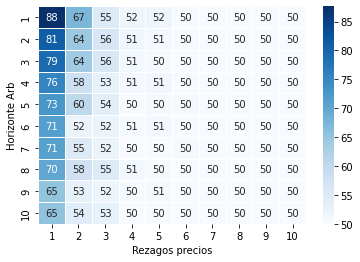

In [12]:
sns.heatmap(table_recall*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 1/Recall.png')

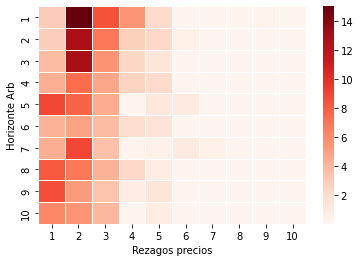

In [13]:
sns.heatmap(table_recall2*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 1/Recall2.png')

In [14]:
table_f1 = pd.pivot_table(resultados, values='f1', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_f1=table_f1[["1","2","3","4","5","6","7","8","9","10"]]         
table_f1.index = table_f1.index.astype("int")                
table_f1.sort_index(ascending=True, inplace=True)

table_f12 = pd.pivot_table(resultados, values='f1', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_f12=table_f12[["1","2","3","4","5","6","7","8","9","10"]]         
table_f12.index = table_f12.index.astype("int")                
table_f12.sort_index(ascending=True, inplace=True)

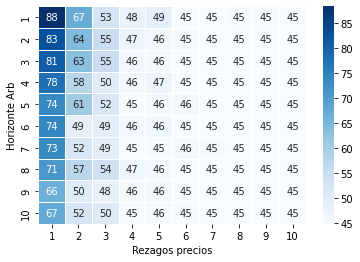

In [15]:
sns.heatmap(table_f1*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 1/F1.png')

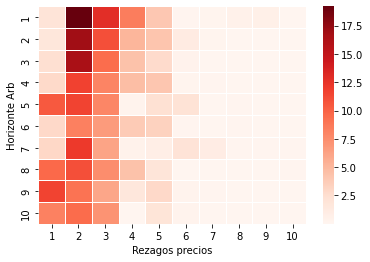

In [16]:
sns.heatmap(table_f12*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 1/F12.png')

In [17]:
with pd.ExcelWriter('Resultados regresión/Resultados 1/Independiente de arbitrajes.xlsx') as writer:
    resultados.to_excel(writer, sheet_name='Resultados generales', index=False)
    
    table_precision.to_excel(writer, sheet_name='Media precision', index=True)
    table_precision2.to_excel(writer, sheet_name='STD precision', index=True)
    
    table_recall.to_excel(writer, sheet_name='Media recall', index=True)
    table_recall2.to_excel(writer, sheet_name='STD recall', index=True)
    
    table_f1.to_excel(writer, sheet_name='Media f1', index=True)
    table_f12.to_excel(writer, sheet_name='STD f1', index=True)

## 2. Predicción: Compra Extranjero - Venta local

In [18]:
#Columnas con información de mercado
model_cols=["Festivo_COL", "Festivo_NYSE", "Next_Day", "Subasta", "PFB_ABIERTO",
            "CIB_ABIERTO", "CIB_close", "COP_close","PFB_close", "Arbitraje_BE_SL"]

In [19]:
#Desplazamiento de la columna de arbitraje en n minutos (1 a 10 minutos) y rezagos de precios de hasta 10 observaciones
df_BeSl=df.copy()
for i in range(1,11):
    col="Target_arb "+str(i)
    col2="COP_close - "+str(i)
    col3="CIB_close - "+str(i)
    col4="PFB_close - "+str(i)
    col5="Spread_BESL_close - "+str(i)
    
    df_BeSl[col]=df_BeSl["Arbitraje_BE_SL"].shift(-i)
    df_BeSl[col2]=df_BeSl["COP_close"].shift(i)
    df_BeSl[col3]=df_BeSl["CIB_close"].shift(i)
    df_BeSl[col4]=df_BeSl["PFB_close"].shift(i)
    df_BeSl[col5]=df_BeSl["Spread_BE_SL"].shift(i)

In [20]:
resultados_globales=[]
for state in range(1,11):
    for i in range(1,11):
        for p in range(1,11):

            y_col="Target_arb "+str(i)

            cols_lags=[]
            for k in range(1, p+1):

                cols_lags= cols_lags + [x for x in list(df_BeSl.columns) if "close - "+str(k) in x]

            if p!=10:
                cols_lags=[x for x in cols_lags if "close - 10" not in x]

            new_model_cols=model_cols.copy()
            new_model_cols.append(y_col)

            new_model_cols=new_model_cols+cols_lags

            model_data=df_BeSl[new_model_cols]
            model_data.dropna(inplace=True)
            X=model_data.drop(y_col, axis=1)
            Y=model_data[y_col]
            x_train, x_test, y_train, y_test = train_test_split(X, 
                                                           Y,random_state=state,
                                                           shuffle=True, stratify=Y)

            l_reg=lr()
            l_reg.fit(x_train, y_train)
            y_pred = l_reg.predict(x_test)
            
            presicion=precision_score(y_test, y_pred, average="macro")
            recall=recall_score(y_test, y_pred, average="macro")
            f1=f1_score(y_test, y_pred, average="macro")

            cols_str=str()
            for w in new_model_cols:
                cols_str=cols_str+w+","

            resultados_globales.append([str(i),str(p), presicion, recall, f1, cols_str,])

In [21]:
resultados = pd.DataFrame(resultados_globales, columns = ['Horizonte Arb', 'Rezagos precios',
                                                          'precision', 'recall', 'f1','cols_str'])
resultados.sample(10)

,Horizonte Arb,Rezagos precios,precision,recall,f1,cols_str
182,9,3,0.803619,0.525795,0.533682,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
629,3,10,0.898823,0.558408,0.589187,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
816,2,7,0.866104,0.566752,0.601324,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
860,7,1,0.884397,0.627659,0.683706,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
969,7,10,0.896916,0.553368,0.581081,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
401,1,2,0.909126,0.660272,0.723578,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
51,6,2,0.844588,0.561458,0.592740,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
263,7,4,0.779097,0.525583,0.533287,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
281,9,2,0.603250,0.505719,0.496748,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
218,2,9,0.864833,0.559255,0.589846,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."


In [22]:
table_precision = pd.pivot_table(resultados, values='precision', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_precision=table_precision[["1","2","3","4","5","6","7","8","9","10"]]         
table_precision.index = table_precision.index.astype("int")                
table_precision.sort_index(ascending=True, inplace=True)

table_precision2 = pd.pivot_table(resultados, values='precision', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_precision2=table_precision2[["1","2","3","4","5","6","7","8","9","10"]]         
table_precision2.index = table_precision2.index.astype("int")                
table_precision2.sort_index(ascending=True, inplace=True)

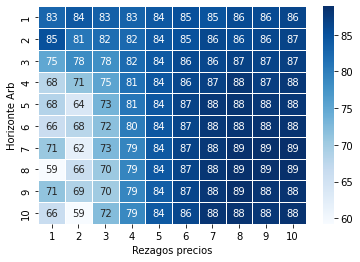

In [23]:
sns.heatmap(table_precision*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 2/Precision.png')

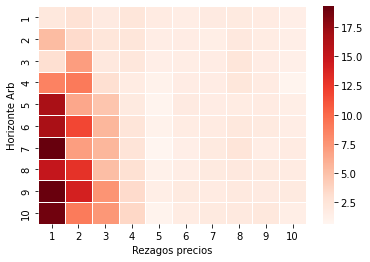

In [24]:
sns.heatmap(table_precision2*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 2/Precision2.png')

In [25]:
table_recall = pd.pivot_table(resultados, values='recall', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_recall=table_recall[["1","2","3","4","5","6","7","8","9","10"]]         
table_recall.index = table_recall.index.astype("int")                
table_recall.sort_index(ascending=True, inplace=True)

table_recall2 = pd.pivot_table(resultados, values='recall', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_recall2=table_recall2[["1","2","3","4","5","6","7","8","9","10"]]         
table_recall2.index = table_recall2.index.astype("int")                
table_recall2.sort_index(ascending=True, inplace=True)

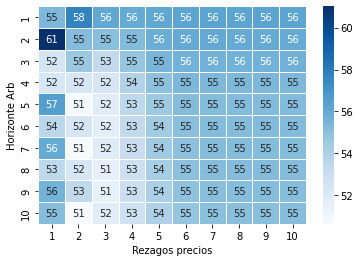

In [26]:
sns.heatmap(table_recall*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 2/Recall.png')

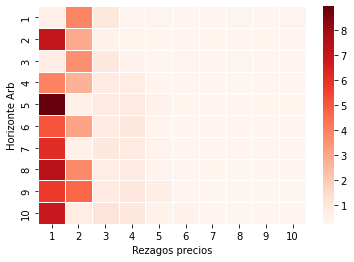

In [27]:
sns.heatmap(table_recall2*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 2/Recall2.png')

In [28]:
table_f1 = pd.pivot_table(resultados, values='f1', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_f1=table_f1[["1","2","3","4","5","6","7","8","9","10"]]         
table_f1.index = table_f1.index.astype("int")                
table_f1.sort_index(ascending=True, inplace=True)

table_f12 = pd.pivot_table(resultados, values='f1', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_f12=table_f12[["1","2","3","4","5","6","7","8","9","10"]]         
table_f12.index = table_f12.index.astype("int")                
table_f12.sort_index(ascending=True, inplace=True)

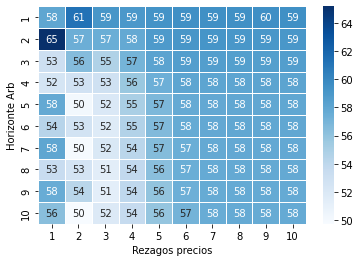

In [29]:
sns.heatmap(table_f1*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 2/F1.png')

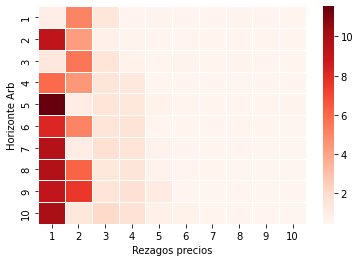

In [30]:
sns.heatmap(table_f12*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 2/F12.png')

In [31]:
with pd.ExcelWriter('Resultados regresión/Resultados 2/Compra Ex - Venta Lo.xlsx') as writer:
    resultados.to_excel(writer, sheet_name='Resultados generales', index=False)
    
    table_precision.to_excel(writer, sheet_name='Media precision', index=True)
    table_precision2.to_excel(writer, sheet_name='STD precision', index=True)
    
    table_recall.to_excel(writer, sheet_name='Media recall', index=True)
    table_recall2.to_excel(writer, sheet_name='STD recall', index=True)
    
    table_f1.to_excel(writer, sheet_name='Media f1', index=True)
    table_f12.to_excel(writer, sheet_name='STD f1', index=True)

## 3. Predicción: Compra Local - Venta Extranjero

In [32]:
#Columnas con información de mercado
model_cols=["Festivo_COL", "Festivo_NYSE", "Next_Day", "Subasta", "PFB_ABIERTO",
            "CIB_ABIERTO", "CIB_close", "COP_close","PFB_close", "Arbitraje_BL_SE"]

In [33]:
#Desplazamiento de la columna de arbitraje en n minutos (1 a 10 minutos) y rezagos de precios de hasta 10 observaciones
df_BlSe=df.copy()
for i in range(1,11):
    col="Target_arb "+str(i)
    col2="COP_close - "+str(i)
    col3="CIB_close - "+str(i)
    col4="PFB_close - "+str(i)
    col5="Spread_BLSE_close - "+str(i)
    
    df_BlSe[col]=df_BeSl["Arbitraje_BE_SL"].shift(-i)
    df_BlSe[col2]=df_BeSl["COP_close"].shift(i)
    df_BlSe[col3]=df_BeSl["CIB_close"].shift(i)
    df_BlSe[col4]=df_BeSl["PFB_close"].shift(i)
    df_BlSe[col5]=df_BeSl["Spread_BL_SE"].shift(i)

In [34]:
resultados_globales=[]
for state in range(1,11):
    for i in range(1,11):
        for p in range(1,11):

            y_col="Target_arb "+str(i)

            cols_lags=[]
            for k in range(1, p+1):

                cols_lags= cols_lags + [x for x in list(df_BlSe.columns) if "close - "+str(k) in x]

            if p!=10:
                cols_lags=[x for x in cols_lags if "close - 10" not in x]

            new_model_cols=model_cols.copy()
            new_model_cols.append(y_col)

            new_model_cols=new_model_cols+cols_lags

            model_data=df_BlSe[new_model_cols]
            model_data.dropna(inplace=True)
            X=model_data.drop(y_col, axis=1)
            Y=model_data[y_col]
            x_train, x_test, y_train, y_test = train_test_split(X, 
                                                           Y,random_state=state,
                                                           shuffle=True, stratify=Y)

            l_reg=lr()
            l_reg.fit(x_train, y_train)
            y_pred = l_reg.predict(x_test)
            presicion=precision_score(y_test, y_pred, average="macro")
            recall=recall_score(y_test, y_pred, average="macro")
            f1=f1_score(y_test, y_pred, average="macro")

            cols_str=str()
            for w in new_model_cols:
                cols_str=cols_str+w+","

            resultados_globales.append([str(i),str(p), presicion, recall, f1, cols_str,])

In [35]:
resultados = pd.DataFrame(resultados_globales, columns = ['Horizonte Arb', 'Rezagos precios',
                                                          'precision', 'recall', 'f1','cols_str'])
resultados.sample(10)

,Horizonte Arb,Rezagos precios,precision,recall,f1,cols_str
571,8,2,0.468767,0.500000,0.483880,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
56,6,7,0.468767,0.500000,0.483880,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
229,3,10,0.468767,0.500000,0.483880,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
837,4,8,0.468767,0.500000,0.483880,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
871,8,2,0.468765,0.499958,0.483859,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
864,7,5,0.468762,0.499915,0.483838,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
874,8,5,0.468762,0.499915,0.483838,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
725,3,6,0.468770,0.500000,0.483882,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
82,9,3,0.468767,0.500000,0.483880,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
351,6,2,0.468770,0.500000,0.483882,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."


In [36]:
table_precision = pd.pivot_table(resultados, values='precision', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_precision=table_precision[["1","2","3","4","5","6","7","8","9","10"]]         
table_precision.index = table_precision.index.astype("int")                
table_precision.sort_index(ascending=True, inplace=True)

table_precision2 = pd.pivot_table(resultados, values='precision', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_precision2=table_precision2[["1","2","3","4","5","6","7","8","9","10"]]         
table_precision2.index = table_precision2.index.astype("int")                
table_precision2.sort_index(ascending=True, inplace=True)

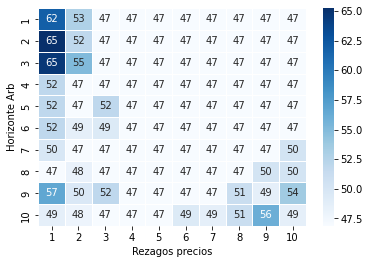

In [37]:
sns.heatmap(table_precision*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 3/Precision.png')

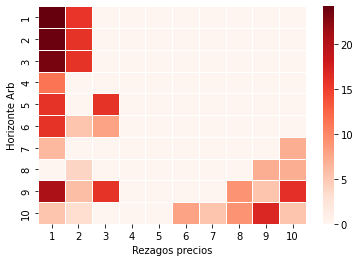

In [38]:
sns.heatmap(table_precision2*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 3/Precision2.png')

In [39]:
table_recall = pd.pivot_table(resultados, values='recall', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_recall=table_recall[["1","2","3","4","5","6","7","8","9","10"]]         
table_recall.index = table_recall.index.astype("int")                
table_recall.sort_index(ascending=True, inplace=True)

table_recall2 = pd.pivot_table(resultados, values='recall', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_recall2=table_recall2[["1","2","3","4","5","6","7","8","9","10"]]         
table_recall2.index = table_recall2.index.astype("int")                
table_recall2.sort_index(ascending=True, inplace=True)

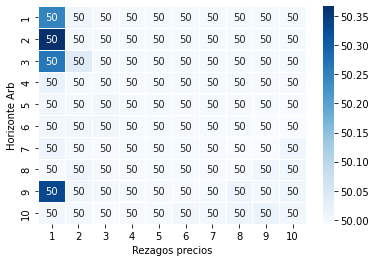

In [40]:
sns.heatmap(table_recall*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 3/Recall.png')

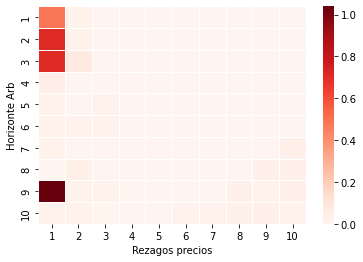

In [41]:
sns.heatmap(table_recall2*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 3/Recall2.png')

In [42]:
table_f1 = pd.pivot_table(resultados, values='f1', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_f1=table_f1[["1","2","3","4","5","6","7","8","9","10"]]         
table_f1.index = table_f1.index.astype("int")                
table_f1.sort_index(ascending=True, inplace=True)

table_f12 = pd.pivot_table(resultados, values='f1', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_f12=table_f12[["1","2","3","4","5","6","7","8","9","10"]]         
table_f12.index = table_f12.index.astype("int")                
table_f12.sort_index(ascending=True, inplace=True)

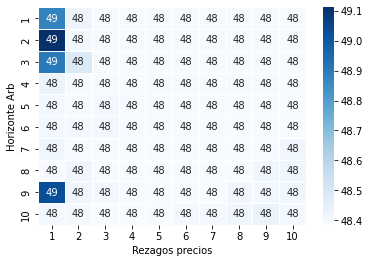

In [43]:
sns.heatmap(table_f1*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 3/F1.png')

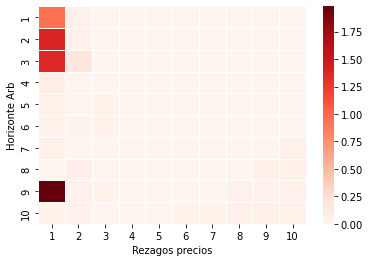

In [44]:
sns.heatmap(table_f12*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 3/F12.png')

In [45]:
with pd.ExcelWriter('Resultados regresión/Resultados 3/Compra Lo - Venta Ex.xlsx') as writer:
    resultados.to_excel(writer, sheet_name='Resultados generales', index=False)
    
    table_precision.to_excel(writer, sheet_name='Media precision', index=True)
    table_precision2.to_excel(writer, sheet_name='STD precision', index=True)
    
    table_recall.to_excel(writer, sheet_name='Media recall', index=True)
    table_recall2.to_excel(writer, sheet_name='STD recall', index=True)
    
    table_f1.to_excel(writer, sheet_name='Media f1', index=True)
    table_f12.to_excel(writer, sheet_name='STD f1', index=True)

## 4. Predicción: Multiclase

In [46]:
#Columnas con información de mercado
model_cols=["Festivo_COL", "Festivo_NYSE", "Next_Day", "Subasta", "PFB_ABIERTO",
            "CIB_ABIERTO", "CIB_close", "COP_close","PFB_close", "Spread_BE_SL","Spread_BL_SE", "Arbitraje_Mul"]

In [47]:
#Desplazamiento de la columna de arbitraje en n minutos (1 a 10 minutos) y rezagos de precios de hasta 10 observaciones
df_mul=df.copy()
for i in range(1,11):
    col="Target_arb "+str(i)
    col2="COP_close - "+str(i)
    col3="CIB_close - "+str(i)
    col4="PFB_close - "+str(i)
    col5="Spread_BLSE_close - "+str(i)
    col6="Spread_BESL_close - "+str(i)
    
    df_mul[col]=df_mul["Arbitraje_Mul"].shift(-i)
    df_mul[col2]=df_mul["COP_close"].shift(i)
    df_mul[col3]=df_mul["CIB_close"].shift(i)
    df_mul[col4]=df_mul["PFB_close"].shift(i)
    df_mul[col5]=df_mul["Spread_BL_SE"].shift(i)
    df_mul[col6]=df_mul["Spread_BE_SL"].shift(i)

In [48]:
resultados_globales=[]
for state in range(1,11):
    for i in range(1,11):
        for p in range(1,11):

            y_col="Target_arb "+str(i)

            cols_lags=[]
            for k in range(1, p+1):

                cols_lags= cols_lags + [x for x in list(df_mul.columns) if "close - "+str(k) in x]

            if p!=10:
                cols_lags=[x for x in cols_lags if "close - 10" not in x]

            new_model_cols=model_cols.copy()
            new_model_cols.append(y_col)

            new_model_cols=new_model_cols+cols_lags

            model_data=df_mul[new_model_cols]
            model_data.dropna(inplace=True)
            X=model_data.drop(y_col, axis=1)
            Y=model_data[y_col]
            x_train, x_test, y_train, y_test = train_test_split(X, 
                                                           Y,random_state=state,
                                                           shuffle=True, stratify=Y)

            l_reg=lr()
            l_reg.fit(x_train, y_train)
            y_pred = l_reg.predict(x_test)
            presicion=precision_score(y_test, y_pred, average="macro")
            recall=recall_score(y_test, y_pred, average="macro")
            f1=f1_score(y_test, y_pred, average="macro")

            cols_str=str()
            for w in new_model_cols:
                cols_str=cols_str+w+","

            resultados_globales.append([str(i),str(p), presicion, recall, f1, cols_str,])

In [49]:
resultados = pd.DataFrame(resultados_globales, columns = ['Horizonte Arb', 'Rezagos precios',
                                                          'precision', 'recall', 'f1','cols_str'])
resultados.sample(10)

,Horizonte Arb,Rezagos precios,precision,recall,f1,cols_str
71,8,2,0.779953,0.447083,0.491300,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
276,8,7,0.778741,0.457705,0.505783,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
708,1,9,0.853226,0.498719,0.562151,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
818,2,9,0.839481,0.496668,0.559889,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
930,4,1,0.751909,0.450651,0.493892,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
763,7,4,0.785611,0.453803,0.496778,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
871,8,2,0.768609,0.447484,0.491523,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
957,6,8,0.765348,0.455878,0.499530,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
705,1,6,0.816996,0.497990,0.559120,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."
29,3,10,0.801564,0.485367,0.542715,"Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_..."


In [50]:
table_precision = pd.pivot_table(resultados, values='precision', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_precision=table_precision[["1","2","3","4","5","6","7","8","9","10"]]         
table_precision.index = table_precision.index.astype("int")                
table_precision.sort_index(ascending=True, inplace=True)

table_precision2 = pd.pivot_table(resultados, values='precision', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_precision2=table_precision2[["1","2","3","4","5","6","7","8","9","10"]]         
table_precision2.index = table_precision2.index.astype("int")                
table_precision2.sort_index(ascending=True, inplace=True)

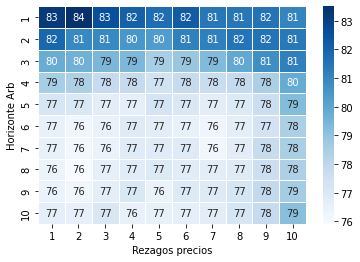

In [51]:
sns.heatmap(table_precision*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 4/Precision.png')

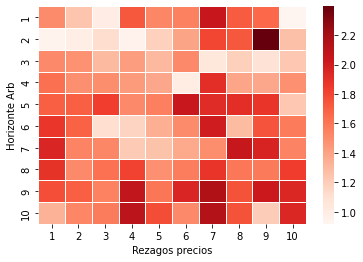

In [52]:
sns.heatmap(table_precision2*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 4/Precision2.png')

In [53]:
table_recall = pd.pivot_table(resultados, values='recall', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_recall=table_recall[["1","2","3","4","5","6","7","8","9","10"]]         
table_recall.index = table_recall.index.astype("int")                
table_recall.sort_index(ascending=True, inplace=True)

table_recall2 = pd.pivot_table(resultados, values='recall', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_recall2=table_recall2[["1","2","3","4","5","6","7","8","9","10"]]         
table_recall2.index = table_recall2.index.astype("int")                
table_recall2.sort_index(ascending=True, inplace=True)

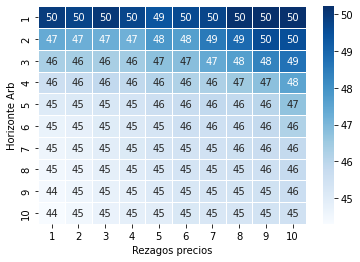

In [54]:
sns.heatmap(table_recall*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 4/Recall.png')

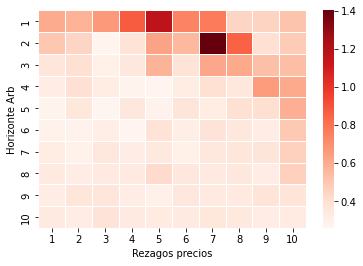

In [55]:
sns.heatmap(table_recall2*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 4/Recall2.png')

In [56]:
table_f1 = pd.pivot_table(resultados, values='f1', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.mean)
table_f1=table_f1[["1","2","3","4","5","6","7","8","9","10"]]         
table_f1.index = table_f1.index.astype("int")                
table_f1.sort_index(ascending=True, inplace=True)

table_f12 = pd.pivot_table(resultados, values='f1', index=['Horizonte Arb'],
                    columns=['Rezagos precios'], aggfunc=np.std)
table_f12=table_f12[["1","2","3","4","5","6","7","8","9","10"]]         
table_f12.index = table_f12.index.astype("int")                
table_f12.sort_index(ascending=True, inplace=True)

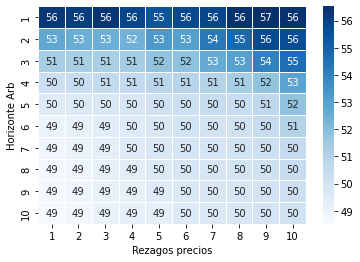

In [57]:
sns.heatmap(table_f1*100, annot=True, linewidth=.5, cmap='Blues')
plt.savefig('Resultados regresión/Resultados 4/F1.png')

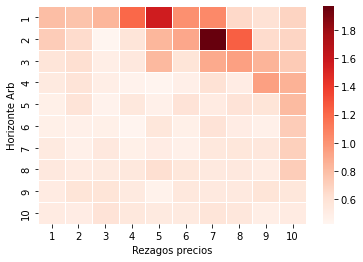

In [58]:
sns.heatmap(table_f12*100,  linewidth=.5, cmap='Reds')
plt.savefig('Resultados regresión/Resultados 4/F12.png')

In [59]:
with pd.ExcelWriter('Resultados regresión/Resultados 4/Multiclase.xlsx') as writer:
    resultados.to_excel(writer, sheet_name='Resultados generales', index=False)
    
    table_precision.to_excel(writer, sheet_name='Media precision', index=True)
    table_precision2.to_excel(writer, sheet_name='STD precision', index=True)
    
    table_recall.to_excel(writer, sheet_name='Media recall', index=True)
    table_recall2.to_excel(writer, sheet_name='STD recall', index=True)
    
    table_f1.to_excel(writer, sheet_name='Media f1', index=True)
    table_f12.to_excel(writer, sheet_name='STD f1', index=True)